# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install lightgbm -U

## Подготовка данных

**Вынесем все импорты**

In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**5 столбцов с ощутимыми пропусками.**

In [5]:
data.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
26834,2016-03-15 17:46:26,3200,small,2003,manual,75,2_reihe,125000,9,petrol,peugeot,NaN,2016-03-15 00:00:00,0,42109,2016-03-24 05:46:15
133927,2016-03-31 02:49:07,2790,wagon,2002,manual,101,focus,90000,5,petrol,ford,NaN,2016-03-30 00:00:00,0,56564,2016-03-31 15:25:10
97925,2016-03-13 22:42:35,5000,bus,2006,manual,0,zafira,70000,10,cng,opel,no,2016-03-13 00:00:00,0,45326,2016-03-27 01:46:35
186234,2016-03-08 16:36:45,300,small,2001,manual,60,fiesta,125000,2,NaN,ford,no,2016-03-08 00:00:00,0,25336,2016-03-23 08:15:53
142010,2016-03-19 11:48:40,300,small,1993,manual,60,fiesta,125000,0,petrol,ford,yes,2016-03-19 00:00:00,0,59071,2016-04-06 14:46:24
226373,2016-03-16 16:49:39,1350,small,2003,manual,0,corsa,150000,5,petrol,opel,no,2016-03-16 00:00:00,0,51580,2016-04-06 21:18:47
102775,2016-04-03 15:45:49,99,NaN,2000,NaN,0,ypsilon,150000,0,NaN,lancia,NaN,2016-04-03 00:00:00,0,95213,2016-04-05 14:46:41
311209,2016-03-22 12:56:36,1649,sedan,1994,manual,75,other,150000,8,gasoline,mercedes_benz,no,2016-03-22 00:00:00,0,49086,2016-03-26 14:17:49
26291,2016-03-19 16:58:25,990,wagon,2000,manual,0,mondeo,150000,12,petrol,ford,no,2016-03-19 00:00:00,0,57074,2016-03-19 16:58:25
218192,2016-04-03 09:53:33,1499,small,2000,manual,58,corsa,150000,9,petrol,opel,no,2016-04-03 00:00:00,0,94447,2016-04-03 09:53:33


<AxesSubplot:>

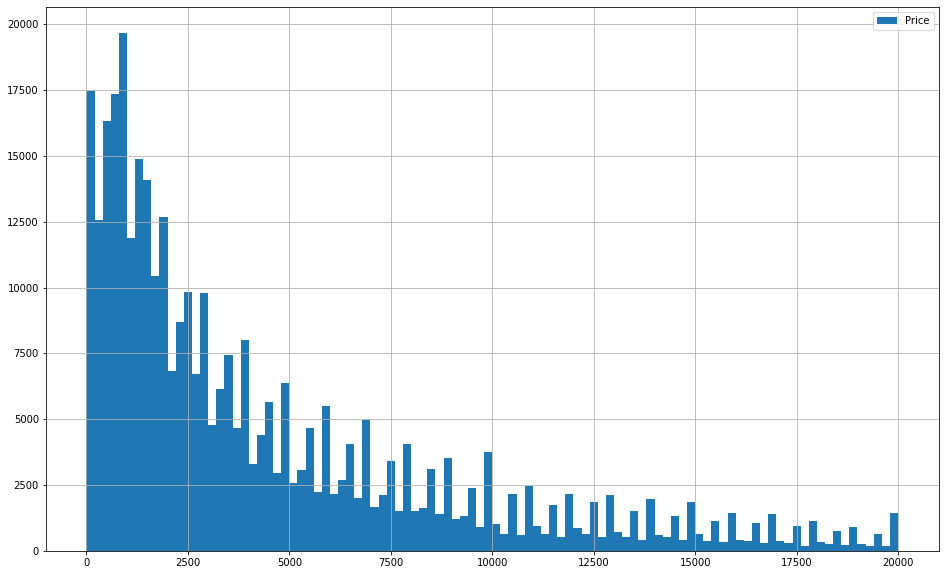

In [6]:
data['Price'].hist(bins=100, figsize=(16,10), legend=True)

**"0" в цене в данном случае можно не считать за ошибку. Это может быть обмен.**

______________

<AxesSubplot:>

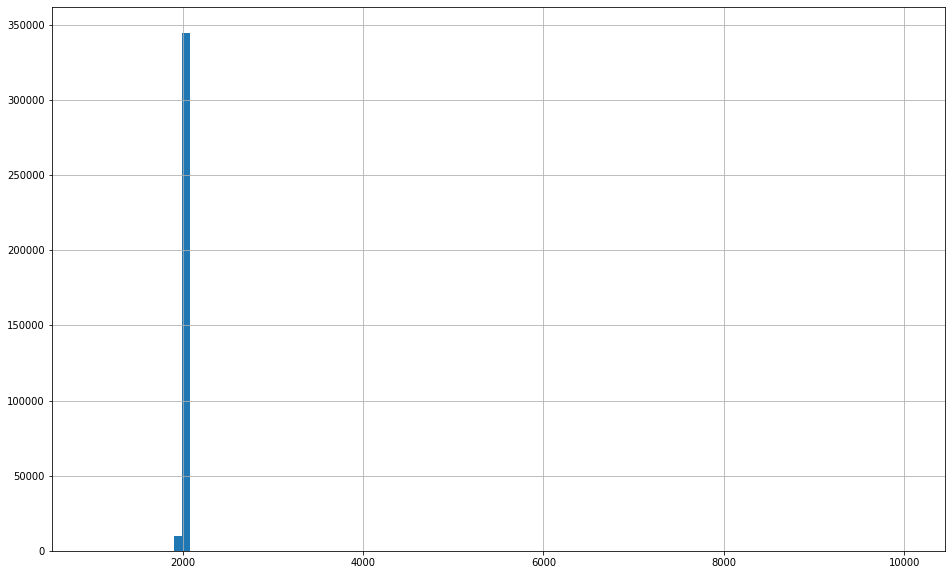

In [7]:
data['RegistrationYear'].hist(bins = 100, figsize=(16,10))

In [8]:
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

**Ага, есть явно нереальные года регистрации.**

In [9]:
data[(data['RegistrationYear'] <= 1910) | (data['RegistrationYear'] > 2019)].count()

DateCrawled          272
Price                272
VehicleType           28
RegistrationYear     272
Gearbox               59
Power                272
Model                134
Kilometer            272
RegistrationMonth    272
FuelType              69
Brand                272
NotRepaired           38
DateCreated          272
NumberOfPictures     272
PostalCode           272
LastSeen             272
dtype: int64

**Почти 300 строк с датой регистрации больше 2019 или меньше 1910 года (я допускаю, что могут быть раритеты с 1910 года). Очень похоже на ошибки\выбросы. Плюс в этих строках много пропусков. Предлагаю дропнуть как мусор.**

In [10]:
data = data[ (data['RegistrationYear'] >= 1910) & (data['RegistrationYear'] <= 2019) ]

In [11]:
data[(data['RegistrationYear'] > 2016) & (data['RegistrationYear'] <= 2019)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11 00:00:00,0,32339,2016-03-12 05:45:02
354140,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29 00:00:00,0,38315,2016-04-06 02:44:27
354203,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17 00:00:00,0,44866,2016-03-29 15:45:04
354253,2016-03-25 09:37:59,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25 00:00:00,0,45527,2016-04-06 07:46:13


<AxesSubplot:>

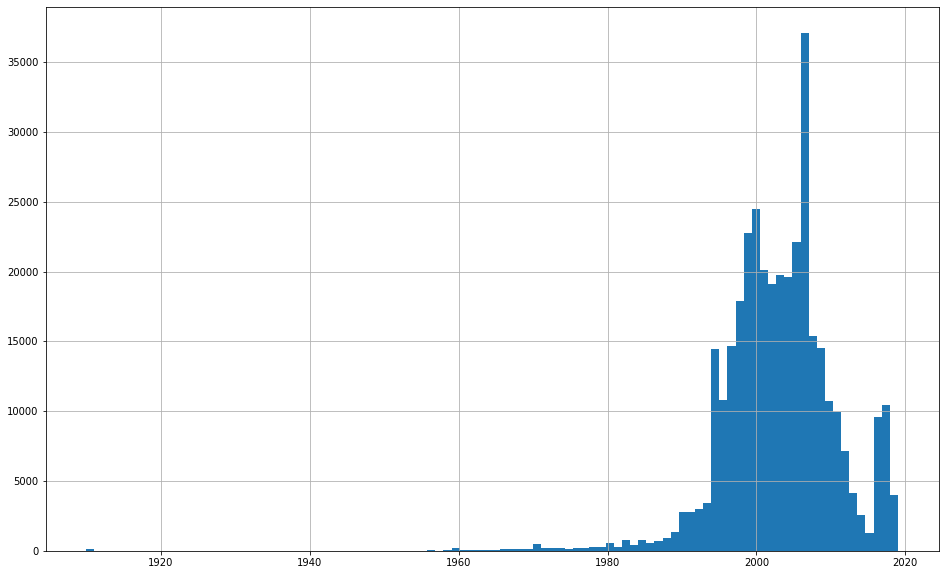

In [12]:
data['RegistrationYear'].hist(bins = 100, figsize=(16,10))

_______

In [13]:
data['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

**Если нет данных о ремонте, то скорее всего его не было**

In [14]:
data['NotRepaired'] = data['NotRepaired'].fillna('yes')

_____

**Заменим количество фотографий на сам факт наличия фотографий (останется просто да\нет)**

In [15]:
data['NumberOfPictures'].unique()

array([0])

**А их тут вообще нет. Можно дропать столбец.**

In [16]:
data = data.drop(['NumberOfPictures'], axis=1)

______

In [17]:
data.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
132046,2016-03-11 20:59:15,2900,bus,1988,manual,75,transporter,150000,7,gasoline,volkswagen,no,2016-03-11 00:00:00,73105,2016-04-02 09:16:55
136377,2016-03-27 11:48:34,2900,sedan,2001,auto,102,bora,70000,9,petrol,volkswagen,no,2016-03-27 00:00:00,21682,2016-03-29 00:17:35
250602,2016-03-12 13:57:31,650,sedan,2003,manual,116,3er,150000,12,petrol,bmw,yes,2016-03-12 00:00:00,13357,2016-03-12 13:57:31
136344,2016-04-04 15:55:39,2499,sedan,2003,auto,125,vectra,150000,3,gasoline,opel,no,2016-04-04 00:00:00,12459,2016-04-06 17:44:56
7378,2016-03-17 18:44:30,679,small,1996,manual,0,punto,150000,7,NaN,fiat,no,2016-03-17 00:00:00,27472,2016-03-25 22:45:53


In [18]:
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

**Попробуем восстановить пропуски сгруппировав по бренду и модели. Одинаковые модели логично должны быть одного типа.**

In [19]:
data['VehicleType'] = data['VehicleType'].fillna(
    data.groupby(['Brand', 'Model'])
['VehicleType'].transform('ffill'))


In [20]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType           6796
RegistrationYear         0
Gearbox              19695
Power                    0
Model                19630
Kilometer                0
RegistrationMonth        0
FuelType             32767
Brand                    0
NotRepaired              0
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

**Ну, с 37,5 тыс. до почти 6,5 тыс. восстановили**

_______

In [21]:
data['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

**"0" можно не считать за пропуск или выброс. Месяц вполне может быть не указан в документах или не внесен в базу.**

______

**Пропуски по типу коробки тоже восстанавливаем по бренду, модели и мощности.**

In [22]:
data['Gearbox'] = data['Gearbox'].fillna(
    data.groupby(['Brand', 'Model', 'Power'])
['Gearbox'].transform('ffill'))

In [23]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType           6796
RegistrationYear         0
Gearbox               4492
Power                    0
Model                19630
Kilometer                0
RegistrationMonth        0
FuelType             32767
Brand                    0
NotRepaired              0
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

_________

**Модель можно попробовать восстановить из бренда, типа кузова и года регистрации**

In [24]:
data['Model'] = data['Model'].fillna(
    data.groupby(['Brand', 'VehicleType', 'RegistrationYear'])
['Model'].transform('ffill'))

In [25]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType           6796
RegistrationYear         0
Gearbox               4492
Power                    0
Model                 9420
Kilometer                0
RegistrationMonth        0
FuelType             32767
Brand                    0
NotRepaired              0
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

<AxesSubplot:>

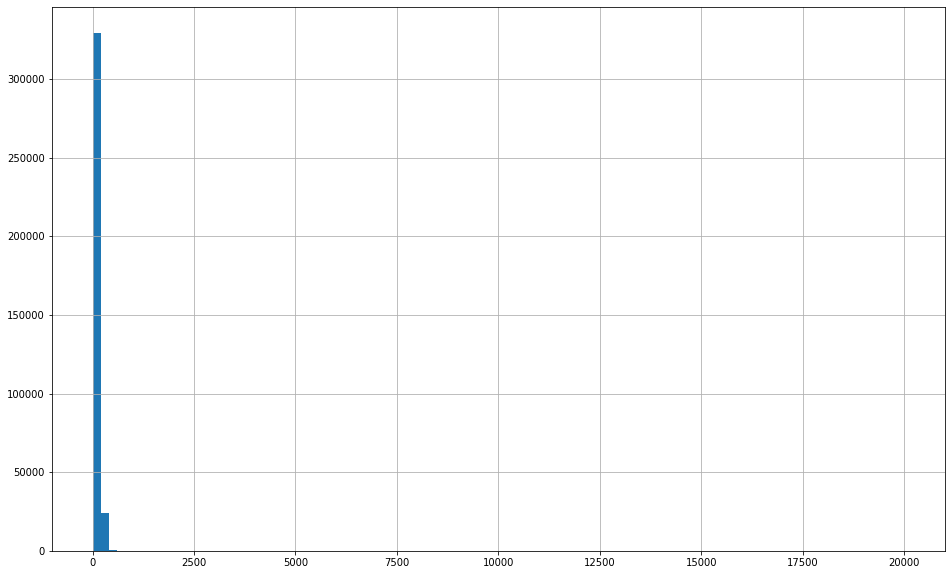

In [26]:
data['Power'].hist(bins=100, figsize=(16,10))

In [27]:
data[(data['Power'] > 500)].count()

DateCrawled          448
Price                448
VehicleType          438
RegistrationYear     448
Gearbox              426
Power                448
Model                429
Kilometer            448
RegistrationMonth    448
FuelType             355
Brand                448
NotRepaired          448
DateCreated          448
PostalCode           448
LastSeen             448
dtype: int64

In [28]:
data[(data['Power'] < 500) & (data['Power'] > 300) ]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
41,2016-03-30 20:38:20,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,yes,2016-03-30 00:00:00,33649,2016-04-03 11:44:49
172,2016-03-07 12:38:19,19750,convertible,2006,manual,305,mustang,50000,7,petrol,ford,no,2016-03-07 00:00:00,38350,2016-03-12 20:18:29
204,2016-03-31 12:58:26,18400,wagon,2011,auto,313,5er,150000,11,gasoline,bmw,no,2016-03-31 00:00:00,52477,2016-03-31 13:44:44
393,2016-04-01 19:49:57,6250,wagon,2016,manual,310,astra,150000,0,NaN,opel,yes,2016-04-01 00:00:00,58809,2016-04-03 16:47:23
485,2016-03-07 21:46:03,15200,sedan,2007,auto,320,s_klasse,150000,7,gasoline,mercedes_benz,no,2016-03-07 00:00:00,29664,2016-04-06 01:45:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354038,2016-04-03 01:57:21,7499,sedan,2003,auto,333,5er,150000,11,petrol,bmw,yes,2016-04-03 00:00:00,48432,2016-04-03 08:48:45
354045,2016-03-22 20:48:48,20000,coupe,2006,auto,476,other,125000,7,petrol,mercedes_benz,no,2016-03-22 00:00:00,38118,2016-03-24 05:16:02
354067,2016-03-20 22:39:32,11500,wagon,2005,auto,340,300c,150000,4,petrol,chrysler,no,2016-03-20 00:00:00,25924,2016-04-01 11:44:42
354096,2016-03-16 13:50:12,15550,sedan,2006,auto,334,a6,90000,1,petrol,audi,yes,2016-03-16 00:00:00,82152,2016-04-06 11:16:18


In [29]:
data[(data['Power'] > 500)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,22043,2016-03-22 21:43:26
2102,2016-03-21 11:55:22,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes,2016-03-21 00:00:00,1723,2016-04-04 04:49:06
3746,2016-03-21 14:48:31,0,NaN,2017,manual,750,NaN,150000,8,petrol,smart,no,2016-03-21 00:00:00,49356,2016-03-24 03:44:59
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03 00:00:00,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,yes,2016-03-29 00:00:00,33154,2016-04-06 05:44:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348968,2016-04-04 18:53:25,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,yes,2016-04-04 00:00:00,28259,2016-04-04 18:53:25
351947,2016-03-07 21:36:19,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no,2016-03-07 00:00:00,66117,2016-03-09 12:47:08
353493,2016-04-02 20:54:21,12500,sedan,2017,manual,2000,other,60000,0,gasoline,chrysler,no,2016-04-02 00:00:00,44145,2016-04-06 21:44:39
353633,2016-03-23 23:55:21,2400,sedan,2007,manual,650,c2,150000,8,petrol,citroen,yes,2016-03-23 00:00:00,45277,2016-03-27 01:15:17


**Так, ну я вижу в мощности двигателя записывали объем в кубических сантиметрах и вообще какие-то спонтанные большие числа. Восстановить реальную мощность по ним сложно. Предлагаю удалить как ошибки.**

In [30]:
data = data[(data['Power'] < 500)]

<AxesSubplot:>

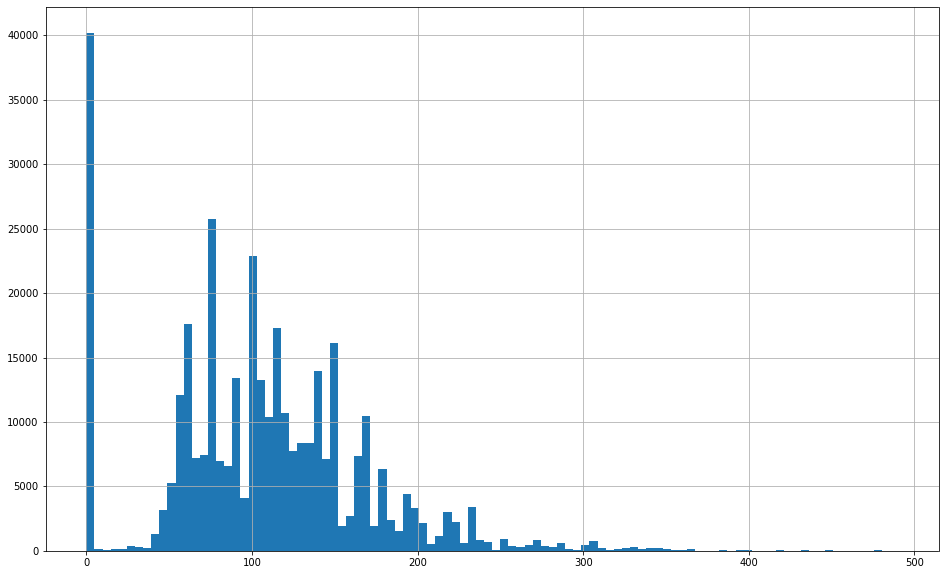

In [31]:
data['Power'].hist(bins=100, figsize=(16,10))

In [32]:
data[(data['Power'] < 30)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,yes,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,yes,2016-03-11 00:00:00,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,manual,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,yes,2016-03-26 00:00:00,56412,2016-03-27 17:43:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,2016-03-07 17:06:35,2600,sedan,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,yes,2016-03-07 00:00:00,61169,2016-03-08 21:28:38
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,81825,2016-04-06 20:47:12
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,2694,2016-03-21 10:42:49


In [33]:
data['Power'] = data['Power'].replace(0, np.nan)

In [34]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType           6785
RegistrationYear         0
Gearbox               4469
Power                40098
Model                 9399
Kilometer                0
RegistrationMonth        0
FuelType             32668
Brand                    0
NotRepaired              0
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

In [35]:
data['Power'] = data['Power'].fillna(
    data.groupby(['Brand', 'Model', 'RegistrationYear'])
['Power'].transform('mean'))

**Много 0 и малых значений. Либо это поле просто заполняли нулями, либо не знают. Думаю можно попробовать заменить нули на средную мощность по модели и году. Хоть какие-то близкие к правде цифры.**

<AxesSubplot:>

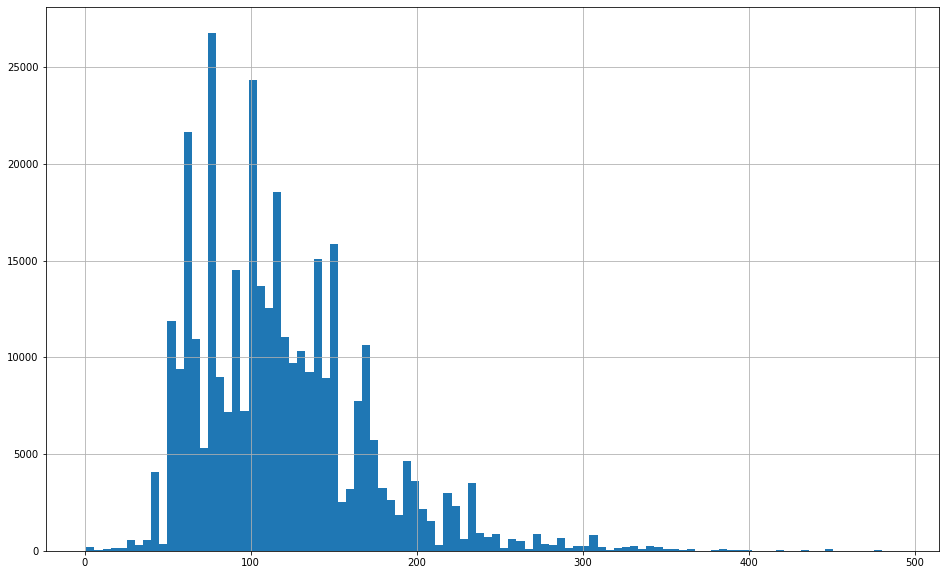

In [36]:
data['Power'].hist(bins=100, figsize=(16,10))

______

**Тип топлива тоже попробуем восстановить по группе.**

In [37]:
data['FuelType'] = data['FuelType'].fillna(
    data.groupby(['Brand', 'Model', 'Power'])
['FuelType'].transform('ffill'))

In [38]:
data.isna().sum()

DateCrawled             0
Price                   0
VehicleType          6785
RegistrationYear        0
Gearbox              4469
Power                4721
Model                9399
Kilometer               0
RegistrationMonth       0
FuelType             7262
Brand                   0
NotRepaired             0
DateCreated             0
PostalCode              0
LastSeen                0
dtype: int64

**Пропусков осталось мало. Остальное придется удалить.**

In [39]:
data = data.dropna()

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340319 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        340319 non-null  object 
 1   Price              340319 non-null  int64  
 2   VehicleType        340319 non-null  object 
 3   RegistrationYear   340319 non-null  int64  
 4   Gearbox            340319 non-null  object 
 5   Power              340319 non-null  float64
 6   Model              340319 non-null  object 
 7   Kilometer          340319 non-null  int64  
 8   RegistrationMonth  340319 non-null  int64  
 9   FuelType           340319 non-null  object 
 10  Brand              340319 non-null  object 
 11  NotRepaired        340319 non-null  object 
 12  DateCreated        340319 non-null  object 
 13  PostalCode         340319 non-null  int64  
 14  LastSeen           340319 non-null  object 
dtypes: float64(1), int64(5), object(9)
memory usage: 41

**В этой задаче даты создания или последнего просмотра не важны, как и почтовый индекс. Удалим лишнее.**

In [41]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'], axis=1)

**Закодируем категориальные признаки.**

In [42]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

enc = OrdinalEncoder()
data[cat_columns] = enc.fit_transform(data[cat_columns]).astype(int)

_______

## Обучение моделей

Разделим датасет на выборки

In [43]:
target = data['Price']
features = data.drop(['Price'], axis=1)

features_train, features_test,\
target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

features_train.shape, target_train.shape, features_test.shape, target_test.shape

((272255, 10), (272255,), (68064, 10), (68064,))

Напишем функцию для кроссвалидации

In [44]:
def rmse(predict, actual):
    score = np.sqrt(mean_squared_error(actual, predict))
    return score

**Начнем с классики. Линейная регрессия.**

In [45]:
scaled_df = data.copy()

target = scaled_df['Price']
features = scaled_df.drop('Price', axis=1)

scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

print('Starting training...')
start_time = time.time()
lr = LinearRegression().fit(features, target)
elapsed_time = time.time() - start_time
print(f"Время на обучение: "
      f"{elapsed_time:.3f} seconds")

rmse_score = make_scorer(rmse, greater_is_better = False)
scores = cross_val_score(lr, features, target, scoring=rmse_score, cv=5)
print(f'RMSE на кроссвалидации: {scores.mean() * -1}')

print('Starting predicting...')
start_time = time.time()
target_predict = lr.predict(features_test)
elapsed_time = time.time() - start_time
print(f"Время на предсказание: "
      f"{elapsed_time:.3f} seconds")


Starting training...
Время на обучение: 2.622 seconds
RMSE на кроссвалидации: 3013.831950591198
Starting predicting...
Время на предсказание: 0.006 seconds


**LightGBM**

In [46]:
lgb_train = lgb.Dataset(features_train, target_train, categorical_feature={2,4,6,9,10,11})
lgb_test = lgb.Dataset(features_test, target_test, reference=lgb_train)

params = {
    'boosting': 'GBDT',
    'metric': 'rmse',
    'num_leaves': 100,
    'verbose': -1,
    'force_row_wise': True,
    'max_depth':10
#    'force_col_wise': True
}

print('Starting training...')
start_time = time.time()

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_test,
                verbose_eval=False
                )

elapsed_time = time.time() - start_time
print(f"Время на обучение: "
      f"{elapsed_time:.3f} seconds")

print('Starting predicting...')
start_time = time.time()

target_predict = gbm.predict(features_test, num_iteration=gbm.best_iteration)

elapsed_time = time.time() - start_time
print(f"Время на предсказание: "
      f"{elapsed_time:.3f} seconds")

rmse_test = mean_squared_error(target_test, target_predict) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

Starting training...
Время на обучение: 5.318 seconds
Starting predicting...
Время на предсказание: 0.799 seconds
The RMSE of prediction is: 1679.5975189313272


**Random Forest**

Сначала подберем гиперпараметры.

In [47]:
%%time
rfr = RandomForestRegressor(random_state=42)
cv = 5
grid_params = {
    'n_estimators' : [50,150,200],
#    'max_features' : ['auto', 'log2', 'sqrt'],
    'max_depth' : [10,20,30]
 }
grid = GridSearchCV(rfr, param_grid=grid_params, cv=cv,
 n_jobs = -1, verbose = 0, return_train_score=True)
grid.fit(features, target)
print('Best hyper parameter:', grid.best_params_)

Best hyper parameter: {'max_depth': 20, 'n_estimators': 200}
CPU times: user 5min 42s, sys: 10.1 s, total: 5min 52s
Wall time: 1h 22min 53s


In [48]:
rfr = RandomForestRegressor(
    random_state=42,
    n_estimators=200,
    max_depth = 20,
)

print('Starting training...')
start_time = time.time()
rfr.fit(features_train, target_train)

elapsed_time = time.time() - start_time
print(f"Время на обучение: "
      f"{elapsed_time:.3f} seconds")

# rmse_score = make_scorer(rmse, greater_is_better = False)
# scores = cross_val_score(rfr, features_train, target_train, scoring=rmse_score, cv=3)
# print(f'RMSE на кроссвалидации: {scores.mean() * -1}')

print('Starting predicting...')
start_time = time.time()
target_predict = rfr.predict(features_test)
elapsed_time = time.time() - start_time
print(f"Время на предсказание: "
      f"{elapsed_time:.3f} seconds")

rmse_test = mean_squared_error(target_test, target_predict) ** 0.5
print(f'RMSE на тестовой выборке: {rmse_test}')


Starting training...
Время на обучение: 141.660 seconds
Starting predicting...
Время на предсказание: 3.234 seconds
RMSE на тестовой выборке: 1697.8930169682167


**Решающее дерево**

In [49]:
dtr = DecisionTreeRegressor()

cv = 5
grid_params = {
    'max_features' : ['auto', 'log2', 'sqrt'],
    'max_depth' : [5,10,20]
}
grid = GridSearchCV(dtr, param_grid=grid_params, cv=cv, 
 n_jobs = -1, verbose = 0, return_train_score=True)
grid.fit(features, target)
print('Best hyper parameter:', grid.best_params_)

Best hyper parameter: {'max_depth': 10, 'max_features': 'auto'}


In [50]:
dtr = DecisionTreeRegressor(max_depth=10, max_features='auto')

print('Starting training...')
start_time = time.time()

dtr.fit(features_train, target_train)

elapsed_time = time.time() - start_time
print(f"Время на обучение: "
      f"{elapsed_time:.3f} seconds")

scores = cross_val_score(dtr, features_train, target_train, scoring=rmse_score, cv=5)
print(f'RMSE на кроссвалидации: {scores.mean() * -1}')

print('Starting predicting...')
start_time = time.time()

target_predict = dtr.predict(features_test)

elapsed_time = time.time() - start_time
print(f"Время на предсказание: "
      f"{elapsed_time:.3f} seconds")

rmse_test = mean_squared_error(target_test, target_predict) ** 0.5
print(f'RMSE на тестовой выборке: {rmse_test}')

Starting training...
Время на обучение: 0.673 seconds
RMSE на кроссвалидации: 2061.047421904654
Starting predicting...
Время на предсказание: 0.013 seconds
RMSE на тестовой выборке: 2073.1028055522906


**Сравним с бейслайн моделью DummyRegressor**

In [51]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features, target)
dummy_regr.predict(features)

scores = cross_val_score(dummy_regr, features, target, scoring=rmse_score, cv=5)
print(f'The RMSE of prediction is: {scores.mean() * -1}')

The RMSE of prediction is: 4512.863779004719


Дамми дал совсем плохие цифры, значит модели предсказывают что-то адекватное.

## Анализ моделей

Очевидно, что качество линейной регрессии никуда не годится. Несмотря на то, что это самая быстрая по времени модель.

Решающее дерево так же довольно быстро обучилось, но метрика по прежнему плохая.

Случайный лес обучался дольше всего. Плюс подбор параметров занимает значительное время. Это не соответствует условию задачи. Скорость модели нам важна.

Наилучшее качество в 1679 показал LightGBM при довольно неплохих показателях времени работы (30 сек.)

**Посмотрим, какие параметры оказываются наиболее важными для модели:**

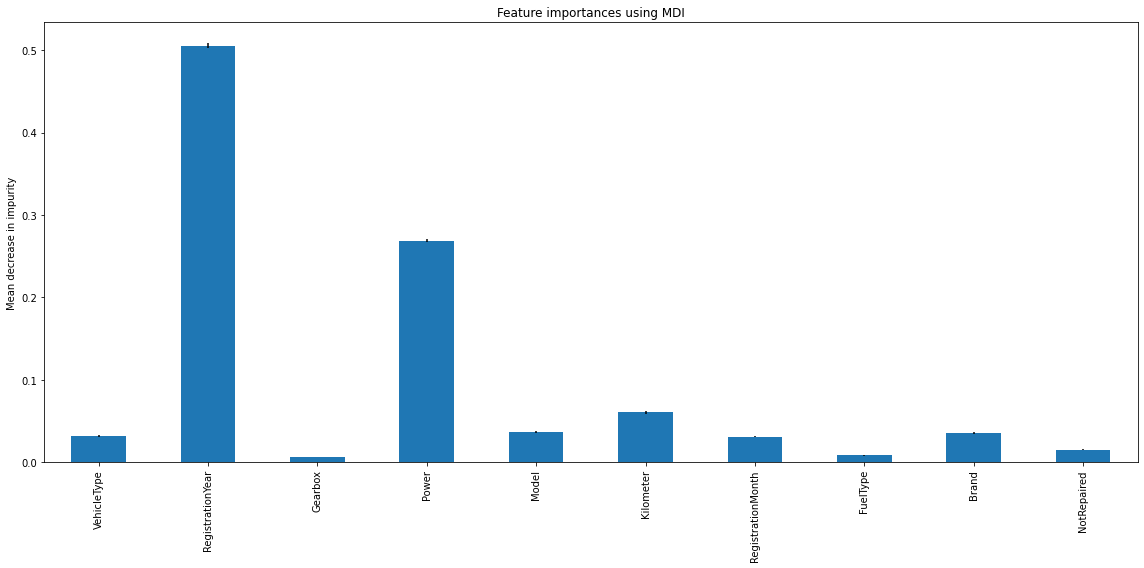

In [52]:
features = data.drop(['Price'], axis=1)
feature_names = list(features.columns)

importances = rfr.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rfr.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots(figsize=(16, 8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Вывод: Ключевое влияние на стоимость автомобиля оказывает год регистрации и ее мощность.**